Il pilastro fondamentale della sua corretta amministrazione del Rischio di Credito risiede nell'accurata stima della Probabilità di Default (PD) di una controparte. 

Il presente lavoro si propone di analizzare in modo approfondito le metodologie avanzate per la misurazione della Probabilità di Default in uno specifico caso e la predizione del possibile fallimento o meno di un’azienda. L’obiettivo dell’analisi è delineare la capacità predittiva relativa alla stima della probabilità di insolvenza di un’azienda. 

Innanzitutto, importiamo le librerie necessarie per l'esecuzione dell'intero script

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV   #libreria necessaria (importa la versione del lasso che sceglie il miglior alpha tramite cv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.metrics import (roc_curve, roc_auc_score, accuracy_score, confusion_matrix, brier_score_loss)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
import statsmodels.api as sm

Il primo passo è stato reperire il dataset dal software AIDA (Sistema Informatizzato delle Aziende Italiane) in cui è stato preso come riferimento un lasso temporale di quattro anni (precisamente dal 2015 al 2019). Il dataset iniziale, una volta inseriti tutti gli step di ricerca presenta un numero di osservazioni pari a 9554 e 73 variabili diverse. (calcolate per ogni anno, da qui il numero elevato) 

Successivamente, una volta stabilito l’insieme di dati su cui operare e condurre l’indagine, è stato svolto un processo di pulizia del dataset in modo tale da giungere ad una situazione in cui le tipologie di variabili fossero coerenti e la gestione di valori mancanti non risultasse più un problema.  


In [2]:
df_risk = pd.read_csv("dataset_nuovo.csv") 

#Numero righe e colonne
print("DIMENSIONI DEL DATASET (NON PANEL):")
print(f"Numero di osservazioni: {df_risk.shape[0]}")
print(f"Numero di variabili: {df_risk.shape[1]}\n")
print(df_risk.head(5))

#Tipologia dei dati
print("TIPOLOGIA DELLE VARIABILI:")
print(df_risk.dtypes.value_counts(), "\n")

#Informazioni generali
print("INFORMAZIONI GENERALI:")
df_risk.info()

DIMENSIONI DEL DATASET (NON PANEL):
Numero di osservazioni: 9554
Numero di variabili: 73

   Codice fiscale EBITDA/Vendite (%)\n%\n2015 EBITDA/Vendite (%)\n%\n2016  \
0    1.051072e+10                       -5.71                      -17.95   
1    8.434331e+09         -1.1400000000000001                        6.41   
2    1.090305e+08                       25.86                       39.06   
3    4.166930e+09                        n.d.                       -95.3   
4    7.577931e+09                        7.25                      -56.41   

  EBITDA/Vendite (%)\n%\n2017 EBITDA/Vendite (%)\n%\n2018  \
0                        1.58                        1.98   
1                        6.05                        7.96   
2                       30.51                        26.4   
3                        5.06                       12.49   
4                       26.99                         3.8   

  EBITDA/Vendite (%)\n%\n2019  \
0                        n.d.   
1          10.

Nel dataset le uniche colonne con valori mancanti sono “Procedura/Cessazione” e “Data di inizio procedura/cessazione”. È normale che queste variabili presentino dei 'missing', perché non tutte le imprese del campione hanno avviato procedure concorsuali o cessato l’attività, quindi l’informazione risulta assente per natura. In realtà, quasi tutte le colonne sono di tipo object invece che numeriche, quindi il numero di NaN potrebbe facilmente aumentare dopo la conversione della variabile nella tipologia voluta.
Inoltre, sarà necessario:
1) sostituire eventuali valori testuali più comuni che rappresentano mancanza con Nan;
2) convertire i campi di tipo object che contengono numeri in veri tipi numerici (float);
3) applicare un arrotondamento (.round()) per rendere più leggibili eventuali valori numerici con molte cifre decimali;
4) controllare la presenza di eventuali nuovi NaN dopo la conversione dei dati.

In [3]:
pd.set_option('future.no_silent_downcasting', True) #bloccare riconversione automatica (per evitare problematiche future)
valori_mancanti_testuali = ["n.d.", "n.s.", "n.a.", "-", "N.D.", "N.S."]
df_risk = df_risk.replace(valori_mancanti_testuali, np.nan)

#Conversione colonna "Codice fiscale" per una migliore visualizzazione
df_risk["Codice fiscale"] = df_risk["Codice fiscale"].astype("string")
df_risk["Codice fiscale"] = df_risk["Codice fiscale"].str.replace(r"\.0$", "", regex=True)

#Escludiamo le colonne che NON devono diventare numeriche
colonne_escluse = [
    "Codice fiscale",                      #identificativo azienda
    "Procedura/Cessazione",                #testo (tipo di procedura)
    "Data di inizio procedura/cessazione"  #data testuale
]

#Tutte le altre colonne sono considerate candidate numeriche
colonne_numeriche = [c for c in df_risk.columns if c not in colonne_escluse]

#Convertiamo in numerico: i valori non convertibili diventano NaN
df_risk[colonne_numeriche] = df_risk[colonne_numeriche].apply(
    pd.to_numeric, errors="coerce"  #il codice procede e trasforma in NaN anche eventuali valori non leggibili
)

#Arrotondiamo a 3 cifre decimali 
df_risk[colonne_numeriche] = df_risk[colonne_numeriche].round(3)
print(df_risk.head(10))

#Controlliamo se la conversione è avvenuta correttamente e se sono apparsi valori mancanti dopo la conversione
print("TIPI DI DATO DOPO LA CONVERSIONE:")
print(df_risk.dtypes.value_counts())

print("VALORI MANCANTI:")
print(df_risk.isna().sum().sort_values(ascending=False))

  Codice fiscale  EBITDA/Vendite (%)\n%\n2015  EBITDA/Vendite (%)\n%\n2016  \
0    10510721003                        -5.71                       -17.95   
1     8434330968                        -1.14                         6.41   
2      109030510                        25.86                        39.06   
3     4166930273                          NaN                       -95.30   
4     7577931210                         7.25                       -56.41   
5      166000240                        59.71                        62.15   
6     8065260963                         6.04                        15.23   
7    12801191003                        12.45                        -6.81   
8     2650960640                         7.17                        25.92   
9     3737180269                         5.31                         3.82   

   EBITDA/Vendite (%)\n%\n2017  EBITDA/Vendite (%)\n%\n2018  \
0                         1.58                         1.98   
1              

Dopo aver effettuato la conversione di alcune variabili e relative operazioni tecniche per verificare la correttezza delle variabili e la presenza dei valori mancanti, si è proceduto optando per la creazione di un panel in modo tale da osservare il comportamento di ogni azienda all’interno del campione su un periodo di tempo più vasto (dal 2015 al 2019), per identificare quali si qualificano come in default e quelle che sono eventualmente a rischio. Si precisa come prima di procedere alla creazione del panel si è dovuto svolgere una serie di operazioni piccole che permettono però una migliore visualizzazione delle variabili e dei valori nel dataset.

In [4]:
#Lavoriamo su una copia del dataframe pulito in precedenza
df_panel = df_risk.copy()

#Modifichiamo i nomi delle colonne preservando "/" per i rapporti, l'informazione su valori percentuali e sulle unità di misura in migliaia di euro
nuovi_nomi = {}  

#Ciclo for per scorrere automaticamente i nomi delle colonne
for col in df_panel.columns:
    #escludiamo le colonne non numeriche, mantenendo così il nome originale
    if col in ["Codice fiscale", "Procedura/Cessazione", "Data di inizio procedura/cessazione"]:
        nuovi_nomi[col] = col
        continue
        
    #controlliamo le colonne con riferimento a percentuali, rapporti o unità di misura in migliaia
    col_originali_lower = col.lower()
    is_percent = ("%" in col_originali_lower) or ("(%)" in col_originali_lower) or ("ratio\n%\n" in col_originali_lower)
    is_migl_eur = ("migl eur" in col_originali_lower)

    #ricerchiamo colonne che hanno un anno nel nome
    ricerca_anno = re.search(r"(20\d{2})", col)

    #separiamo la parte d'interesse del nome della colonna dall'anno (se trova un anno tiene solamente la parte del nome 'restante' altrimenti lascia
    #il nome originale
    if ricerca_anno:
        anno = ricerca_anno.group(1)              
        restante = col[:ricerca_anno.start()]         
    else:
        anno = None
        restante = col

    #pulizia della parte del nome restante 
    restante = restante.replace("\n", " ")            
    restante = restante.lower()                       

    #rimuoviamo la dicitura "migl eur" e simboli di percentuale dal nome restante
    restante = restante.replace("migl eur", "")
    restante = restante.replace("%", "").replace("(%)", "")

    
    restante = re.sub(r"[^a-z0-9/]+", "_", restante)         #trova tutte le sequenze di uno o più caratteri che non sono lettere minuscole, numeri o /
    restante = re.sub(r"_+", "_", restante).strip("_")       #sostituisce sequenze di più _ consecutivi con uno solo

    #aggiungiamo le informazioni rimosse in precedenza sull'unità di misura e sulla percentuale
    if is_percent:
        restante = f"{restante}_%"
    if is_migl_eur:
        restante = f"{restante}_migliaia_euro"

    #ricostruiamo il nome finale
    if anno is not None:
        nuovi_nomi[col] = f"{restante}_{anno}"      
    else:
        nuovi_nomi[col] = restante                  

#Aggiorniamo il nome delle colonne nel dataframe
df_panel = df_panel.rename(columns=nuovi_nomi)

print("ESEMPIO NUOVI NOMI COLONNE:")
print(df_panel.columns[:20])

#Uniamo le colonne che appartengono alla stessa variabile (e che differiscono solo per l'anno) e costruiamo il panel
variabili_panel = sorted({
    c.rsplit("_", 1)[0]              
    for c in df_panel.columns
    if re.search(r"_20\d{2}$", c)    
})

panel = pd.wide_to_long(
    df_panel,
    stubnames=variabili_panel,
    i="Codice fiscale",     #codice fiscale come identificativo dell'impresa
    j="Anno",               #nome colonna che contiene l'anno
    sep="_",                #separatore tra nome variabile e anno
    suffix="20\\d{2}"       #per riconoscere il suffisso anno
).reset_index()             

#Ordiniamo le osservazioni in base al codice fiscale e all'anno di riferimento
panel = panel.sort_values(by=["Codice fiscale", "Anno"]).reset_index(drop=True) 

print("DIMENSIONI DEL DATASET PANEL:")
print(panel.shape)
panel.head(10)

ESEMPIO NUOVI NOMI COLONNE:
Index(['Codice fiscale', 'ebitda/vendite_%_2015', 'ebitda/vendite_%_2016',
       'ebitda/vendite_%_2017', 'ebitda/vendite_%_2018',
       'ebitda/vendite_%_2019', 'redditivit_del_totale_attivo_roa_%_2015',
       'redditivit_del_totale_attivo_roa_%_2016',
       'redditivit_del_totale_attivo_roa_%_2017',
       'redditivit_del_totale_attivo_roa_%_2018',
       'redditivit_del_totale_attivo_roa_%_2019',
       'redditivit_delle_vendite_ros_%_2015',
       'redditivit_delle_vendite_ros_%_2016',
       'redditivit_delle_vendite_ros_%_2017',
       'redditivit_delle_vendite_ros_%_2018',
       'redditivit_delle_vendite_ros_%_2019', 'utile_netto_migliaia_euro_2015',
       'utile_netto_migliaia_euro_2016', 'utile_netto_migliaia_euro_2017',
       'utile_netto_migliaia_euro_2018'],
      dtype='object')
DIMENSIONI DEL DATASET PANEL:
(47770, 18)


,Codice fiscale,Anno,Data di inizio procedura/cessazione,Procedura/Cessazione,debt/ebitda_ratio_%,debt/equity_ratio_%,ebitda/vendite_%,grado_di_copertura_degli_interessi_passivi_%,indice_corrente,indice_di_indebitam_a_breve_%,indice_di_liquidit,patrimonio_netto_migliaia_euro,redditivit_del_capitale_proprio_roe_%,redditivit_del_totale_attivo_roa_%,redditivit_delle_vendite_ros_%,ricavi_delle_vendite_migliaia_euro,totale_attivo_migliaia_euro,utile_netto_migliaia_euro
0,10001790962,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001790962,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001790962,2017,NaN,NaN,97.20,12.43,34.76,1.56,1.31,0.03,1.31,337.831,10.08,0.42,19.89,120.133,5953.785,34.065
3,10001790962,2018,NaN,NaN,0.00,0.00,60.66,6.92,2.60,0.05,2.60,1674.331,20.10,5.70,NaN,288.582,6093.758,336.500
4,10001790962,2019,NaN,NaN,0.00,0.00,34.48,NaN,2.39,0.05,2.39,1906.878,9.74,1.32,22.39,297.954,5971.466,185.816
5,10006791007,2015,NaN,NaN,9.74,1.87,51.91,2.02,1.48,0.19,0.46,320.971,-3.12,2.18,22.67,112.049,1231.914,-9.999
6,10006791007,2016,NaN,NaN,NaN,NaN,52.46,8.52,1.99,0.10,1.99,430.418,25.43,18.19,NaN,311.589,1070.090,109.447
7,10006791007,2017,NaN,NaN,NaN,NaN,74.15,6.94,0.46,0.16,0.46,460.717,6.58,6.24,NaN,126.385,947.466,30.300
8,10006791007,2018,NaN,NaN,3.80,0.73,73.90,7.24,0.28,0.25,0.28,490.131,6.00,6.45,NaN,127.200,913.865,29.412
9,10006791007,2019,NaN,NaN,3.69,0.61,71.16,7.34,0.25,0.27,0.25,515.772,4.97,5.74,NaN,118.410,872.216,25.642


Definizione variabile target (default anno successivo): Partendo da diverse procedure inserite nella colonna 'Procedura/Cessazione', si determinano tutti gli eventi classificabili come default (1) o meno (0). 
Tutte quelle procedure che possono derivare da un default, ma non lo implicano necessariamente non sono state inserite, al fine di mantenere una definizione di default più severa. 
Ciò implica una riduzione del numero complessivo di casi classificati come default, ma al tempo stesso un aumento dell’affidabilità dell’identificazione, limitando la categoria ai soli più probabili     
Successivamente, si crea una prima variabile binaria chiamata default, che vale 1 se l’anno del bilancio coincide con l’anno della procedura di default e 0 altrimenti. In questo modo si identifica, per ogni impresa e per ogni anno, se essa è entrata in default proprio in quell’anno degli eventi. Su questa base viene costruita la variabile default_next_year, che assume valore 1 se l’impresa entrerà in default nell’anno successivo e 0 altrimenti. Questa operazione si ottiene spostando in avanti di un anno (tramite la funzione shift(-1)) l’informazione sul default, in modo da collegare ogni osservazione dell’anno t con l’evento di default dell’anno t+1.

Il dataset viene quindi pulito eliminando le righe prive di informazione sull’anno successivo e convertendo la variabile target in formato numerico. Vengono inoltre eliminate le colonne intermedie utilizzate per il calcolo per ottenere un dataset finale più snello e pronto per l’analisi.

Infine, si analizza la distribuzione della variabile default_next_year per verificare la presenza di sbilanciamento tra imprese “sane” e imprese “in default”.

Questa procedura consente di passare da informazioni testuali sulle procedure aziendali a una variabile target binaria coerente e rigorosa, che indica se un’impresa entrerà in default l’anno successivo.

In [5]:
#Ricerchiamo i valori unici contenuti nella colonna "Procedura/Cessazione" per scoprire tutte le tipologie di procedura presenti nel dataset
print("Valori unici nella colonna 'Procedura/Cessazione':\n")
print(panel["Procedura/Cessazione"].value_counts(dropna=False))

#Definiamo tra le varie procedure gli eventi considerabili default (sono inclusi anche eventi che spesso portano al default in futuro) 
procedure_default = [
     #sempre o spesso associate al default
    "Fallimento",
    "Liquidazione giudiziale",
    "Liquidazione coatta amministrativa",
    "Scioglimento e liquidazione",
    "Concordato preventivo",
    "Concordato preventivo omologato",
    "Concordato semplificato",
    "Stato di insolvenza",
    "Cancellazione dal registro delle imprese",
    "Cancellata d'ufficio ai sensi art. 2490 c.c.",
    "Chiusura del fallimento",
    "Chiusura della liquidazione",
    "Chiusura per fallimento o liquidazione",
    #quasi default
    "Accordo di ristrutturazione dei debiti",
    "Accordi di ristrutturazione dei debiti",
    "Amministrazione giudiziaria",
    "Procedimento unitario",
    "Misure cautelari e protettive"
]

#Tutte quelle procedure che possono derivare da un default, ma non lo implicano necessariamente (es:liquidazione volontaria, scioglimento e liquidazione,
#liquidazione/scioglimento senza ulteriori motivazioni) non sono state inserite al fine di mantenere una definizione di default più severa: ciò implica
#una riduzione del numero complessivo di casi classificati come default, ma al tempo stesso un aumento della precisione dell’identificazione,
#limitando la categoria di default ai soli eventi più probabili (aumenta però il rischio di overfitting).

#Creazione di una variabile binaria: 1 se la procedura è un evento di default, 0 altrimenti
panel["default_procedura"] = (
    panel["Procedura/Cessazione"].isin(procedure_default)
).astype(int)

panel

Valori unici nella colonna 'Procedura/Cessazione':

Procedura/Cessazione
NaN                                                                                                        42415
Trasferimento in altra provincia                                                                            2130
Concordato preventivo                                                                                       1460
Fallimento                                                                                                   640
Scioglimento e liquidazione                                                                                  410
Liquidazione volontaria                                                                                      185
Scioglimento                                                                                                  75
Amministrazione giudiziaria                                                                                   75
Accordo di ristrutturaz

,Codice fiscale,Anno,Data di inizio procedura/cessazione,Procedura/Cessazione,debt/ebitda_ratio_%,debt/equity_ratio_%,ebitda/vendite_%,grado_di_copertura_degli_interessi_passivi_%,indice_corrente,indice_di_indebitam_a_breve_%,indice_di_liquidit,patrimonio_netto_migliaia_euro,redditivit_del_capitale_proprio_roe_%,redditivit_del_totale_attivo_roa_%,redditivit_delle_vendite_ros_%,ricavi_delle_vendite_migliaia_euro,totale_attivo_migliaia_euro,utile_netto_migliaia_euro,default_procedura
0,10001790962,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,10001790962,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10001790962,2017,NaN,NaN,97.2,12.43,34.76,1.56,1.31,0.03,1.31,337.831,10.08,0.42,19.89,120.133,5953.785,34.065,0
3,10001790962,2018,NaN,NaN,0.0,0.00,60.66,6.92,2.60,0.05,2.60,1674.331,20.10,5.70,NaN,288.582,6093.758,336.500,0
4,10001790962,2019,NaN,NaN,0.0,0.00,34.48,NaN,2.39,0.05,2.39,1906.878,9.74,1.32,22.39,297.954,5971.466,185.816,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47765,9993930966,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
47766,9993930966,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
47767,9993930966,2017,NaN,NaN,NaN,NaN,2.43,5.60,1.44,1.00,1.17,10.313,3.04,1.86,2.43,20.702,27.109,0.313,0
47768,9993930966,2018,NaN,NaN,NaN,NaN,2.22,NaN,1.01,1.00,0.60,14.070,26.70,3.99,1.86,202.402,94.183,3.757,0


In [6]:
#Conversione della data di inizio procedura in formato datetime, gestendo eventuali errori e formato giorno/mese/anno
panel["Data di inizio procedura/cessazione"] = pd.to_datetime(
    panel["Data di inizio procedura/cessazione"], 
    errors="coerce", 
    dayfirst=True
)

#Estrazione dell’anno dalla data di inizio procedura
panel["Anno_procedura"] = panel["Data di inizio procedura/cessazione"].dt.year

#Creazione di una variabile che vale 1 se l’anno del bilancio coincide con l’anno della procedura di default
panel["default"] = (
    (panel["Anno"] == panel["Anno_procedura"]) &
    (panel["default_procedura"] == 1)
).astype(int)

panel

,Codice fiscale,Anno,Data di inizio procedura/cessazione,Procedura/Cessazione,debt/ebitda_ratio_%,debt/equity_ratio_%,ebitda/vendite_%,grado_di_copertura_degli_interessi_passivi_%,indice_corrente,indice_di_indebitam_a_breve_%,...,patrimonio_netto_migliaia_euro,redditivit_del_capitale_proprio_roe_%,redditivit_del_totale_attivo_roa_%,redditivit_delle_vendite_ros_%,ricavi_delle_vendite_migliaia_euro,totale_attivo_migliaia_euro,utile_netto_migliaia_euro,default_procedura,Anno_procedura,default
0,10001790962,2015,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
1,10001790962,2016,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
2,10001790962,2017,NaT,NaN,97.2,12.43,34.76,1.56,1.31,0.03,...,337.831,10.08,0.42,19.89,120.133,5953.785,34.065,0,NaN,0
3,10001790962,2018,NaT,NaN,0.0,0.00,60.66,6.92,2.60,0.05,...,1674.331,20.10,5.70,NaN,288.582,6093.758,336.500,0,NaN,0
4,10001790962,2019,NaT,NaN,0.0,0.00,34.48,NaN,2.39,0.05,...,1906.878,9.74,1.32,22.39,297.954,5971.466,185.816,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47765,9993930966,2015,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
47766,9993930966,2016,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
47767,9993930966,2017,NaT,NaN,NaN,NaN,2.43,5.60,1.44,1.00,...,10.313,3.04,1.86,2.43,20.702,27.109,0.313,0,NaN,0
47768,9993930966,2018,NaT,NaN,NaN,NaN,2.22,NaN,1.01,1.00,...,14.070,26.70,3.99,1.86,202.402,94.183,3.757,0,NaN,0


In [7]:
#Creazione della variabile target: indica se l’impresa entrerà in default l’anno successivo
panel["default_next_year"] = (
    panel
    .groupby("Codice fiscale")["default"]
    .shift(-1)    #per spostare in avanti di un anno il valore, così ogni osservazione dell’anno t sa se l’impresa entrerà in default all’anno t+1.
)

panel

,Codice fiscale,Anno,Data di inizio procedura/cessazione,Procedura/Cessazione,debt/ebitda_ratio_%,debt/equity_ratio_%,ebitda/vendite_%,grado_di_copertura_degli_interessi_passivi_%,indice_corrente,indice_di_indebitam_a_breve_%,...,redditivit_del_capitale_proprio_roe_%,redditivit_del_totale_attivo_roa_%,redditivit_delle_vendite_ros_%,ricavi_delle_vendite_migliaia_euro,totale_attivo_migliaia_euro,utile_netto_migliaia_euro,default_procedura,Anno_procedura,default,default_next_year
0,10001790962,2015,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0.0
1,10001790962,2016,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0.0
2,10001790962,2017,NaT,NaN,97.2,12.43,34.76,1.56,1.31,0.03,...,10.08,0.42,19.89,120.133,5953.785,34.065,0,NaN,0,0.0
3,10001790962,2018,NaT,NaN,0.0,0.00,60.66,6.92,2.60,0.05,...,20.10,5.70,NaN,288.582,6093.758,336.500,0,NaN,0,0.0
4,10001790962,2019,NaT,NaN,0.0,0.00,34.48,NaN,2.39,0.05,...,9.74,1.32,22.39,297.954,5971.466,185.816,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47765,9993930966,2015,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0.0
47766,9993930966,2016,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0.0
47767,9993930966,2017,NaT,NaN,NaN,NaN,2.43,5.60,1.44,1.00,...,3.04,1.86,2.43,20.702,27.109,0.313,0,NaN,0,0.0
47768,9993930966,2018,NaT,NaN,NaN,NaN,2.22,NaN,1.01,1.00,...,26.70,3.99,1.86,202.402,94.183,3.757,0,NaN,0,0.0


In [8]:
#Creazione del dataset per il modello: rimozione delle righe senza informazione sul default dell’anno successivo
df_model = panel.dropna(subset=["default_next_year"]).copy()

# Conversione della variabile target in intero (0/1)
df_model["default_next_year"] = df_model["default_next_year"].astype(int)

df_model

,Codice fiscale,Anno,Data di inizio procedura/cessazione,Procedura/Cessazione,debt/ebitda_ratio_%,debt/equity_ratio_%,ebitda/vendite_%,grado_di_copertura_degli_interessi_passivi_%,indice_corrente,indice_di_indebitam_a_breve_%,...,redditivit_del_capitale_proprio_roe_%,redditivit_del_totale_attivo_roa_%,redditivit_delle_vendite_ros_%,ricavi_delle_vendite_migliaia_euro,totale_attivo_migliaia_euro,utile_netto_migliaia_euro,default_procedura,Anno_procedura,default,default_next_year
0,10001790962,2015,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0
1,10001790962,2016,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0
2,10001790962,2017,NaT,NaN,97.20,12.43,34.76,1.56,1.31,0.03,...,10.08,0.42,19.89,120.133,5953.785,34.065,0,NaN,0,0
3,10001790962,2018,NaT,NaN,0.00,0.00,60.66,6.92,2.60,0.05,...,20.10,5.70,NaN,288.582,6093.758,336.500,0,NaN,0,0
5,10006791007,2015,NaT,NaN,9.74,1.87,51.91,2.02,1.48,0.19,...,-3.12,2.18,22.67,112.049,1231.914,-9.999,0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47763,9989050969,2018,NaT,NaN,0.00,0.00,4.74,NaN,1.33,1.00,...,23.08,13.70,3.59,437.116,114.544,9.332,0,NaN,0,0
47765,9993930966,2015,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0
47766,9993930966,2016,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0
47767,9993930966,2017,NaT,NaN,NaN,NaN,2.43,5.60,1.44,1.00,...,3.04,1.86,2.43,20.702,27.109,0.313,0,NaN,0,0


In [9]:
#Visualizzazione delle colonne del nuovo dataset
df_model.columns

#Rimozione delle colonne non più necessarie (intermedie o informative solo per la costruzione del target)
df_model = df_model.drop(
    columns=["Procedura/Cessazione", "Data di inizio procedura/cessazione", "Anno_procedura", "default", "default_procedura"],
    errors="ignore"    # così non crasha se un nome non esiste
)

df_model

,Codice fiscale,Anno,debt/ebitda_ratio_%,debt/equity_ratio_%,ebitda/vendite_%,grado_di_copertura_degli_interessi_passivi_%,indice_corrente,indice_di_indebitam_a_breve_%,indice_di_liquidit,patrimonio_netto_migliaia_euro,redditivit_del_capitale_proprio_roe_%,redditivit_del_totale_attivo_roa_%,redditivit_delle_vendite_ros_%,ricavi_delle_vendite_migliaia_euro,totale_attivo_migliaia_euro,utile_netto_migliaia_euro,default_next_year
0,10001790962,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,10001790962,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10001790962,2017,97.20,12.43,34.76,1.56,1.31,0.03,1.31,337.831,10.08,0.42,19.89,120.133,5953.785,34.065,0
3,10001790962,2018,0.00,0.00,60.66,6.92,2.60,0.05,2.60,1674.331,20.10,5.70,NaN,288.582,6093.758,336.500,0
5,10006791007,2015,9.74,1.87,51.91,2.02,1.48,0.19,0.46,320.971,-3.12,2.18,22.67,112.049,1231.914,-9.999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47763,9989050969,2018,0.00,0.00,4.74,NaN,1.33,1.00,0.99,40.427,23.08,13.70,3.59,437.116,114.544,9.332,0
47765,9993930966,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
47766,9993930966,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
47767,9993930966,2017,NaN,NaN,2.43,5.60,1.44,1.00,1.17,10.313,3.04,1.86,2.43,20.702,27.109,0.313,0


In [10]:
#Scopriamo la distribuzione della variabile target (default dell’anno successivo)
print("DISTRIBUZIONE VARIABILE TARGET:")
print(df_model["default_next_year"].value_counts())
print("PERCENTUALE:")
print(df_model["default_next_year"].value_counts(normalize=True) * 100)

# Salvataggio in formato CSV
df_model.to_csv("dataset_finale.csv", index=False, encoding="utf-8")

DISTRIBUZIONE VARIABILE TARGET:
default_next_year
0    37805
1      411
Name: count, dtype: int64
PERCENTUALE:
default_next_year
0    98.924534
1     1.075466
Name: proportion, dtype: float64


Una volta effettuata la variabile target e aver stabilito le condizioni per condurre un'analisi corretta senza eventuali tipologie di errori, iniziamo entrando nel vivo dell'analisi. In primo luogo abbiamo iniziato conducendo un'analisi descrittiva iniziale sul dataset pulito da tutte le sue imperfezioni.

In [11]:
df_descrittiva = pd.read_csv("dataset_finale.csv") 
df_descrittiva

,Codice fiscale,Anno,debt/ebitda_ratio_%,debt/equity_ratio_%,ebitda/vendite_%,grado_di_copertura_degli_interessi_passivi_%,indice_corrente,indice_di_indebitam_a_breve_%,indice_di_liquidit,patrimonio_netto_migliaia_euro,redditivit_del_capitale_proprio_roe_%,redditivit_del_totale_attivo_roa_%,redditivit_delle_vendite_ros_%,ricavi_delle_vendite_migliaia_euro,totale_attivo_migliaia_euro,utile_netto_migliaia_euro,default_next_year
0,10001790962,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,10001790962,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10001790962,2017,97.20,12.43,34.76,1.56,1.31,0.03,1.31,337.831,10.08,0.42,19.89,120.133,5953.785,34.065,0
3,10001790962,2018,0.00,0.00,60.66,6.92,2.60,0.05,2.60,1674.331,20.10,5.70,NaN,288.582,6093.758,336.500,0
4,10006791007,2015,9.74,1.87,51.91,2.02,1.48,0.19,0.46,320.971,-3.12,2.18,22.67,112.049,1231.914,-9.999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38211,9989050969,2018,0.00,0.00,4.74,NaN,1.33,1.00,0.99,40.427,23.08,13.70,3.59,437.116,114.544,9.332,0
38212,9993930966,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
38213,9993930966,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
38214,9993930966,2017,NaN,NaN,2.43,5.60,1.44,1.00,1.17,10.313,3.04,1.86,2.43,20.702,27.109,0.313,0


In [12]:
desc=df_descrittiva.drop(columns=["Codice fiscale", "Anno", "default_next_year"]).describe()

visualizzazione_descrittiva = df_descrittiva.drop(columns=["Codice fiscale", "Anno", "default_next_year"]).describe()

#Le 3 colonne selezionate mostravano le statistiche descrittive in notazione scientifica. Per una maggior coerenza e visibilità si è optato per 
#modificare il formato con cui venivano mostrate
visualizzazione_descrittiva.style.format({
    "patrimonio_netto_migliaia_euro": "{:,.2f}".format,
    "ricavi_delle_vendite_migliaia_euro": "{:,.2f}".format,
    "totale_attivo_migliaia_euro": "{:,.2f}".format
})

,debt/ebitda_ratio_%,debt/equity_ratio_%,ebitda/vendite_%,grado_di_copertura_degli_interessi_passivi_%,indice_corrente,indice_di_indebitam_a_breve_%,indice_di_liquidit,patrimonio_netto_migliaia_euro,redditivit_del_capitale_proprio_roe_%,redditivit_del_totale_attivo_roa_%,redditivit_delle_vendite_ros_%,ricavi_delle_vendite_migliaia_euro,totale_attivo_migliaia_euro,utile_netto_migliaia_euro
count,18488.000000,18655.000000,28554.000000,19996.000000,28734.000000,30888.000000,29234.000000,"31,079.00",28373.000000,31082.000000,23761.000000,"31,096.00","31,096.00",31096.000000
mean,1.331605,1.693039,6.173297,42.304336,1.791505,0.760985,1.446887,"2,216.79",9.315826,3.557148,4.284148,"3,511.13","15,284.78",47.868847
std,38.340953,19.013707,73.404179,73.008121,1.610446,0.314547,1.538336,"64,253.54",31.638904,25.327940,11.593585,"42,471.05","887,317.22",4479.759666
min,-996.770000,-964.580000,-999.390000,0.000000,0.000000,0.000000,0.000000,"-337,589.92",-149.940000,-876.110000,-49.970000,0.00,0.00,-249520.947000
25%,0.000000,0.000000,2.982500,4.010000,0.910000,0.590000,0.510000,23.44,-0.020000,-0.080000,1.170000,59.25,188.26,-1.773000
50%,0.140000,0.120000,8.285000,11.370000,1.310000,0.930000,1.020000,95.76,6.620000,3.040000,4.160000,282.56,591.87,5.696000
75%,3.092500,1.180000,20.890000,41.020000,2.090000,1.000000,1.720000,420.58,21.920000,8.337500,9.630000,"1,085.91","1,901.08",31.541000
max,894.880000,837.690000,921.730000,399.620000,9.990000,1.000000,9.990000,"5,694,613.00",149.910000,698.280000,29.990000,"2,550,547.00","80,725,931.00",265101.000000


ANALISI PANORAMICA GENERALE
L’analisi descrittiva delle variabili economico-finanziarie mette in luce una forte eterogeneità strutturale tra le imprese del campione. Le distribuzioni risultano asimmetriche, con outlier rilevanti e valori estremi. La distanza significativa tra media e mediana in molti indicatori, suggerisce la presenza di aziende con dimensioni diverse e condizioni economiche fortemente compromesse. 
Questa struttura così irregolare introduce già in fase esplorativa una serie di criticità: la probabile multicollinearità tra variabili finanziarie, la presenza di indici costruiti su rapporti tra loro molto correlati.   
In questo contesto, l’uso del LASSO può rivelarsi particolarmente utile. Il metodo è infatti in grado di selezionare in modo automatico le variabili realmente informative, riducendo la ridondanza e attenuando gli effetti delle feature più instabili o dominate dal rumore e dagli outlier. Al tempo stesso, contribuisce a stabilizzare il modello in presenza di rapporti poco robusti o altamente volatili.
Nel complesso, ci si può attendere che il LASSO svolga un ruolo di filtro e di semplificazione, riportando ordine all’interno di un dataset complesso e disomogeneo e restituendo un insieme di covariate più coerente, interpretabile e adatto alla successiva fase di modellazione predittiva.


<Axes: >

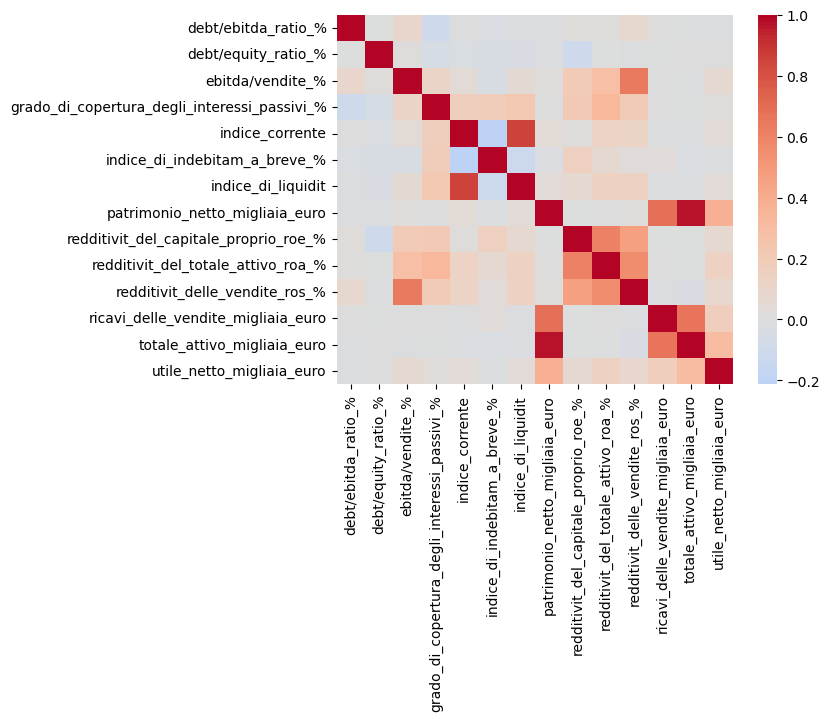

In [13]:
correlazioni = df_descrittiva.drop(columns=["Codice fiscale", "Anno", "default_next_year"]).corr()
sns.heatmap(correlazioni, cmap="coolwarm", center=0)

La matrice di correlazione evidenzia la presenza di gruppi ben definiti di variabili fortemente legate tra loro. Questo pattern conferma una multicollinearità significativa all’interno del dataset, un elemento che rende particolarmente appropriato l’impiego del LASSO, capace di penalizzare e, quando necessario, eliminare le variabili ridondanti. 
Le correlazioni tra le singole variabili esplicative e il target di default risultano invece molto deboli. 

In [14]:
analisi_correlazioni = df_descrittiva.drop(columns=["Codice fiscale", "Anno"]).corr()
analisi_correlazioni["default_next_year"].sort_values(ascending=False)

default_next_year                               1.000000
ricavi_delle_vendite_migliaia_euro              0.017432
debt/ebitda_ratio_%                             0.005555
totale_attivo_migliaia_euro                     0.000525
debt/equity_ratio_%                            -0.004229
indice_di_indebitam_a_breve_%                  -0.008113
patrimonio_netto_migliaia_euro                 -0.014279
grado_di_copertura_degli_interessi_passivi_%   -0.017476
redditivit_del_capitale_proprio_roe_%          -0.046973
indice_corrente                                -0.052869
indice_di_liquidit                             -0.055861
ebitda/vendite_%                               -0.089357
redditivit_delle_vendite_ros_%                 -0.123267
utile_netto_migliaia_euro                      -0.123561
redditivit_del_totale_attivo_roa_%             -0.131690
Name: default_next_year, dtype: float64

L’analisi delle correlazioni rispetto al target mostra che nessuna variabile presenta un legame lineare forte con il default: i valori si collocano infatti in un intervallo molto ristretto, compreso tra –0.13 e +0.02. Gli indicatori di redditività risultano essere i più informativi in termini lineari, ma la loro correlazione rimane comunque solo moderatamente negativa. 

Questo quadri confermano che la probabilità di default non può essere ricondotta all’effetto di una singola variabile, ma rappresenta un fenomeno complesso, influenzato da molteplici dimensioni aziendali. Di conseguenza, per cogliere appieno i segnali deboli distribuiti tra le diverse feature è necessario ricorrere a modelli multivariati, più adatti a rappresentare la natura multifattoriale del rischio di insolvenza.


In [15]:
#Ordiniamo il panel
panel = df_descrittiva.sort_values(["Codice fiscale", "Anno"])

#Creiamo il dataframe delle autocorrelazioni
autocorrelazioni = {}

for col in panel.drop(columns=["Codice fiscale", "Anno", "default_next_year"]).columns:
    #lag temporale per impresa
    panel[col + "_lag"] = panel.groupby("Codice fiscale")[col].shift(1)
    
    #Calcoliamo correlazione tra valore t e t-1
    autocorrelazioni[col] = panel[[col, col + "_lag"]].corr().iloc[0, 1]

df_autocorrelazioni = pd.DataFrame.from_dict(autocorrelazioni, orient="index", columns=["autocorrelazione"])
df_autocorrelazioni.sort_values("autocorrelazione", ascending=False)

,autocorrelazione
totale_attivo_migliaia_euro,0.999870
patrimonio_netto_migliaia_euro,0.995586
ricavi_delle_vendite_migliaia_euro,0.992907
indice_di_indebitam_a_breve_%,0.855460
indice_corrente,0.739730
indice_di_liquidit,0.736473
grado_di_copertura_degli_interessi_passivi_%,0.607590
redditivit_delle_vendite_ros_%,0.477546
utile_netto_migliaia_euro,0.463350
redditivit_del_capitale_proprio_roe_%,0.417738


L’analisi dell’autocorrelazione intra-impresa evidenzia che le variabili dimensionali presentano una persistenza estremamente elevata nel tempo (autocorr. > 0.99), segnalando che la dimensione aziendale cambia molto poco di anno in anno. Gli indicatori di liquidità e di copertura mostrano una persistenza medio-alta, suggerendo un comportamento relativamente stabile. Al contrario, le variabili di redditività e gli indici di indebitamento risultano decisamente più volatili (autocorr. tra 0.1 e 0.5), indicando una forte variabilità annuale. 

Questa struttura dinamica ha implicazioni dirette per la modellazione: le variabili altamente persistenti forniscono informazioni soprattutto di livello (caratteristiche strutturali dell’impresa), mentre quelle a bassa persistenza forniscono informazioni cicliche o transitorie, spesso più rumorose. 

Durante la selezione delle variabili, il LASSO tenderà a penalizzare le variabili troppo volatili e poco stabili, che contribuiscono poco alla capacità predittiva, e a mantenere invece le variabili più informative e costanti nel tempo. In questo modo, la regolarizzazione aiuta a individuare gli indicatori che offrono un contributo robusto alla previsione del default, filtrando automaticamente sia la ridondanza tra variabili molto collegate sia il rumore generato dalle variabili meno persistenti.

Dalla descrittiva emergono aspetti rilevanti per la costruzione del modello: 

1- Elevata variabilità e presenza di outlier: 

Molti indicatori finanziari mostrano valori estremi o distorti. Questo giustifica l’utilizzo della winsorization per stabilizzare la distribuzione delle variabili ed evitare che pochi valori anomali influenzino eccessivamente la stima del modello. 

2- Forte multicollinearità tra variabili finanziarie: 

Le variabili dimensionali, gli indici di marginalità e gli indicatori di liquidità mostrano correlazioni molto elevate tra loro. 

3- Scarsa correlazione tra singole variabili e default: 

Nessun indicatore mostra da solo una forte relazione con l’insolvenza, suggerendo che il segnale predittivo è debole e distribuito su più dimensioni.  

4- Persistenza temporale diversa tra famiglie di indicatori: 

Le variabili dimensionali sono estremamente persistenti nel tempo, mentre redditività e indebitamento risultano più volatili. Questo aiuta a capire quali variabili forniscono informazione strutturale e quali invece catturano dinamiche di breve periodo, utile per l’interpretazione finale del modello. 

Una volta terminata l'analisi descrittiva che consente di cogliere le prime informazioni importanti relative al dataset e alle relazioni presenti al suo interno, continuiamo l'indagine procedendo con l'applicazione del modello di regressione lineare LASSO (Least Absolute Shrinkage and Selection Operator), che si distingue dalle altre tipologie per una duplice funzione: 

Regolarizzazione (Shrinkage): Previene l'overfitting. 

Selezione delle Variabili (Feature Selection): Identifica le variabili più rilevanti. 

Nel contesto di tale analisi, per la modellazione del rischio di default, il LASSO è stato utilizzato in modo cruciale per scegliere un sottoinsieme parsimonioso di indicatori di bilancio da includere nel modello finale. 

Infatti, una delle caratteristiche fondamentali del LASSO fa riferimento alla caratteristica distintiva derivante dall'uso del valore assoluto (β) e la sua capacità di forzare a zero i coefficienti delle variabili che contribuiscono meno a spiegare la variabile dipendente. Nel caso specifico, partendo da un insieme iniziale di dieci variabili, il LASSO ha selezionato soltanto le sette più utili alla spiegazione del fenomeno, generando un modello più compatto e interpretabile. La riduzione della dimensionalità rappresenta un passaggio strutturale necessario per aumentare solidità e credibilità degli output previsti.

In [16]:
df_lasso = pd.read_csv("dataset_finale.csv") 

#Definiamo la variabile target e ne verifichiamo valori e tipologia 
variabile_target = 'default_next_year'
print("VALORI VARIABILE TARGET:")
print(df_lasso[variabile_target].unique())
print("TIPOLOGIA DELLA VARIABILE TARGET:", df_lasso[variabile_target].dtype)

#Creazione variabile target e features
y = df_lasso[variabile_target]                   #variabile target
X = df_lasso.drop(columns=[variabile_target, "Codice fiscale", "Anno"])    #tutte le colonne tranne le colonne identificative sono le features

print("Shape di X:", X.shape)   #per vedere il numero di osservazioni (righe) e variabili (colonne)
print("Shape di y:", y.shape)   #verifichiamo che le osservazioni default siano dello stesso numero (n input=n output)

#Controlliamo che siano state eliminate
print("COLONNE RIMANENTI:")
print(X.columns.tolist())
print(X.head())

VALORI VARIABILE TARGET:
[0 1]
TIPOLOGIA DELLA VARIABILE TARGET: int64
Shape di X: (38216, 14)
Shape di y: (38216,)
COLONNE RIMANENTI:
['debt/ebitda_ratio_%', 'debt/equity_ratio_%', 'ebitda/vendite_%', 'grado_di_copertura_degli_interessi_passivi_%', 'indice_corrente', 'indice_di_indebitam_a_breve_%', 'indice_di_liquidit', 'patrimonio_netto_migliaia_euro', 'redditivit_del_capitale_proprio_roe_%', 'redditivit_del_totale_attivo_roa_%', 'redditivit_delle_vendite_ros_%', 'ricavi_delle_vendite_migliaia_euro', 'totale_attivo_migliaia_euro', 'utile_netto_migliaia_euro']
   debt/ebitda_ratio_%  debt/equity_ratio_%  ebitda/vendite_%  \
0                  NaN                  NaN               NaN   
1                  NaN                  NaN               NaN   
2                97.20                12.43             34.76   
3                 0.00                 0.00             60.66   
4                 9.74                 1.87             51.91   

   grado_di_copertura_degli_interessi_pa

In [17]:
#Ulteriori controlli
#Le colonne non numeriche non possono entrare direttamente nel lasso
print("VERIFICA COLONNE NON NUMERICHE:")
colonne_non_numeriche = X.select_dtypes(include=['object']).columns
print(colonne_non_numeriche)                                        

#Verifichiamo se esistono colonne con valori nulli (NaN): lasso non gestisce NaN
print("NUMERO NaN PER COLONNA") 
valori_mancanti = X.isnull().sum()
print(valori_mancanti[valori_mancanti > 0])

VERIFICA COLONNE NON NUMERICHE:
Index([], dtype='object')
NUMERO NaN PER COLONNA
debt/ebitda_ratio_%                             19728
debt/equity_ratio_%                             19561
ebitda/vendite_%                                 9662
grado_di_copertura_degli_interessi_passivi_%    18220
indice_corrente                                  9482
indice_di_indebitam_a_breve_%                    7328
indice_di_liquidit                               8982
patrimonio_netto_migliaia_euro                   7137
redditivit_del_capitale_proprio_roe_%            9843
redditivit_del_totale_attivo_roa_%               7134
redditivit_delle_vendite_ros_%                  14455
ricavi_delle_vendite_migliaia_euro               7120
totale_attivo_migliaia_euro                      7120
utile_netto_migliaia_euro                        7120
dtype: int64


In [18]:
#Rimuoviamo colonne con troppi NaN (poco informative)
percentuale_NaN = X.isnull().mean() * 100  #calcola la percentuale di NaN per ogni colonna

print("% VALORI MANCANTI PER COLONNA:")
print(percentuale_NaN.sort_values(ascending=False))

#Selezioniamo solo le colonne con meno del 30% di NaN
X = X.loc[:, percentuale_NaN < 30]

print("COLONNE RESTANTI (meno del 30% di valori mancanti):")
print(X.columns.tolist())
print(f"Numero colonne mantenute: {X.shape[1]}")

% VALORI MANCANTI PER COLONNA:
debt/ebitda_ratio_%                             51.622357
debt/equity_ratio_%                             51.185367
grado_di_copertura_degli_interessi_passivi_%    47.676366
redditivit_delle_vendite_ros_%                  37.824471
redditivit_del_capitale_proprio_roe_%           25.756228
ebitda/vendite_%                                25.282604
indice_corrente                                 24.811597
indice_di_liquidit                              23.503245
indice_di_indebitam_a_breve_%                   19.175215
patrimonio_netto_migliaia_euro                  18.675424
redditivit_del_totale_attivo_roa_%              18.667574
ricavi_delle_vendite_migliaia_euro              18.630940
totale_attivo_migliaia_euro                     18.630940
utile_netto_migliaia_euro                       18.630940
dtype: float64
COLONNE RESTANTI (meno del 30% di valori mancanti):
['ebitda/vendite_%', 'indice_corrente', 'indice_di_indebitam_a_breve_%', 'indice_di_liquid

In [19]:
#Sostituiamo i valori mancanti rimanenti: si sceglie la mediana perché più robusta in presenza di outlier e variabilità elevata
imputer = SimpleImputer(strategy='median') 

X_imputed = imputer.fit_transform(X)    #sostituisce il valore nullo con la mediana (fit: calcola mediana e transform sostituisce con i NaN)

X = pd.DataFrame(X_imputed, columns=X.columns) #viene ricreato il dataframe X con i nuovi valori 

#Controllo finale
print("VALORI MANCANTI DOPO L'IMPUTAZIONE:")
print(X.isnull().sum().sum())                  
print(f"Numero di variabili finali pronte per il LASSO: {X.shape[1]}")

VALORI MANCANTI DOPO L'IMPUTAZIONE:
0
Numero di variabili finali pronte per il LASSO: 10


Dopo questi check siamo sicuri di avere solo colonne numeriche e senza NaN.
Ora occorre gestire tre problematiche:

- gestione degli eventuali outlier estremi
  
- standardizzazione

- multicollinearità

Per quanto riguarda il trattamento dei valori estremi, sono disponibili due strategie principali: 

- La prima è la winsorization, che consiste nel sostituire i valori al di sotto di un certo percentile con il valore del percentile stesso, e analogamente sostituire i valori superiori al 99° percentile con il valore di quel percentile. Questa tecnica ha diversi vantaggi tra cui mantenere la scala originale della variabile e riduzione dell’influenza degli outlier senza alterare la struttura lineare. 

- La seconda possibilità è la trasformazione logaritmica, generalmente applicata a variabili con distribuzioni molto asimmetriche e a coda lunga, come ricavi, debiti o totale attivo. La trasformazione log(x + 1) riduce la variabilità, rende la distribuzione più simile a quella normale, stabilizza i coefficienti e preserva l’ordine relativo tra le imprese. 

Nel nostro caso, considerando gli obiettivi dell’analisi e il tipo di modello impiegato, si è optato per la winsorization. Questa scelta consente di contenere l’effetto dei valori estremi senza cancellare la variabilità economica che caratterizza le imprese del campione. 

In [20]:
#Gestione outlier
X_wins = X.copy()   #copia delle X per modificarle

for col in X.columns:          #ciclo for perchè la winsorization si applica individualmente ad ogni variabile
    #calcoliamo i percentili 1% e 99% per ogni variabile
    lower = X[col].quantile(0.01)
    upper = X[col].quantile(0.99)
    
    #Winsorizzazione dei valori estremi
    X_wins[col] = X[col].clip(lower=lower, upper=upper)

X = X_wins   #aggiorniamo le X con le variabili winsorizzate

#Verifichiamo che non ci siano più valori estremi (o una riduzione)
print("CONTROLLO OUTLIER DOPO WINSORIZATION:")
print(X.describe())

CONTROLLO OUTLIER DOPO WINSORIZATION:
       ebitda/vendite_%  indice_corrente  indice_di_indebitam_a_breve_%  \
count      38216.000000     38216.000000                   38216.000000   
mean           8.990432         1.662653                       0.793394   
std           36.645548         1.363633                       0.290508   
min         -230.110500         0.040000                       0.000000   
25%            4.590000         1.050000                       0.700000   
50%            8.285000         1.310000                       0.930000   
75%           14.580000         1.740000                       1.000000   
max           86.218500         7.960000                       1.000000   

       indice_di_liquidit  patrimonio_netto_migliaia_euro  \
count        38216.000000                    38216.000000   
mean             1.335376                      791.328013   
std              1.298002                     2876.178142   
min              0.020000                 

In [21]:
#Standardizzazione
# Creazione oggetto scaler
scaler = StandardScaler()

#Calcolo media e deviazione standard per ogni colonna (fit) e applicazione della formula di standardizzazione (transform)
X_scaled = scaler.fit_transform(X)

X = pd.DataFrame(X_scaled, columns=X.columns)  #dataset ricostruito con nomi colonne originali

#Controllo visivo
print(X.head())

#Controllo statistico: media ≈ 0 e deviazione standard ≈ 1
print("MEDIA E DEVIAZIONE STANDARDI DI OGNI VARIABILE:")
print("MEDIA (deve essere ≈ 0):")
print(X.mean().round(2))
print("DEVIAZIONE STANDARD (deve essere ≈ 1):")
print(X.std().round(2))

   ebitda/vendite_%  indice_corrente  indice_di_indebitam_a_breve_%  \
0         -0.019250        -0.258617                       0.470239   
1         -0.019250        -0.258617                       0.470239   
2          0.703221        -0.258617                      -2.627827   
3          1.410001         0.687398                      -2.558981   
4          1.171224        -0.133948                      -2.077060   

   indice_di_liquidit  patrimonio_netto_migliaia_euro  \
0           -0.242973                       -0.241840   
1           -0.242973                       -0.241840   
2           -0.019550                       -0.157676   
3            0.974297                        0.307010   
4           -0.674411                       -0.163538   

   redditivit_del_capitale_proprio_roe_%  redditivit_del_totale_attivo_roa_%  \
0                              -0.082651                           -0.077009   
1                              -0.082651                           -0.

La divisione del dataset in set di Training set e Test set  è un passaggio fondamentale, poiché lo scopo di un modello non è semplicemente quello di *descrivere* bene i dati che ha già visto, ma di *predire* con accuratezza i risultati su nuovi dati mai incontrati prima (test).

Per simulare questo scenario reale, si divide il dataset iniziale in due porzioni distinte:

1. Training Set (Set di Addestramento)
Utilizzo: Questa porzione (80%) viene utilizzata per addestrare il modello. Il modello, in questa fase, impara le relazioni tra le variabili esplicative (le metriche di bilancio) e la variabile target ($Default_{t+1}$). Il LASSO (e la sua calibrazione $\alpha$) hanno "visto" solo il Training Set per determinare quali dei 10 indicatori sono effettivamente predittivi e quali coefficienti azzerare.

2. Test Set (Set di Validazione o Verifica)
Utilizzo: Questa porzione (il restante 20%) viene tenuta completamente separata e sconosciuta al modello durante l'addestramento. Viene usata solo alla fine per valutare le performance finali del modello (il $R^2$ in questo caso). Inoltre fornisce una misura imparziale della capacità del modello di generalizzare. Se un modello si comporta molto bene sul Training Set ma male sul Test Set, significa che ha memorizzato i dati di addestramento anziché imparare le regole generali, e siamo dunque nel caso di overfitting.




Un aspetto che è importante sottolineare è che va effettuata proprio prima della LASSO la suddivisione tra training set e test set poiché:

Vogliamo che ciò che "impara" il modello sia basato solo sui dati di training (anche la feature selection)

Il test set deve servire solo per valutare la capacità predittiva del modello finale

altrimenti si corre il rischio di Data Leakage (perdita di dati). Infatti, se il LASSO avesse avuto accesso ai dati del Test Set durante la sua fase di selezione, avrebbe inconsciamente scelto le variabili che funzionavano meglio anche per quel 20% di dati. Ciò avrebbe portato a una valutazione finale troppo ottimistica, vanificando lo scopo del Test Set come misuratore imparziale di generalizzazione.`

Nello script è stata utilizzata l'opzione stratify=y` (dove y è la variabile default_next_year), poiché essendo il default un evento raro (un dataset sbilanciato), stratify=y  garantisce che la proporzione di aziende in default sia identica sia nel set di Training che nel set di Test. Ciò impedisce che il Test Set finisca con troppo pochi (o troppi) casi di default, rendendo la valutazione finale inaffidabile.

In [22]:
#DIVISIONE TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       #20% test, 80% train
    random_state=42,
    stratify=y           #tiene bilanciata la distribuzione default/non default nel train e nel test
)

#Verifichiamo che sia stata rispettata la proporzione voluta
print("DIMENSIONE X_train:", X_train.shape)
print("DIMENSIONE X_test:", X_test.shape)
print("DIMENSIONE y_train:", y_train.shape)
print("DIMENSIONE y_test:", y_test.shape)

DIMENSIONE X_train: (30572, 10)
DIMENSIONE X_test: (7644, 10)
DIMENSIONE y_train: (30572,)
DIMENSIONE y_test: (7644,)


In [23]:
#LASSO SOLO SUL TRAIN (selezione variabili)

#Metodo LassoCV: sceglie automaticamente il miglior alpha tramite cross-validation
lasso = LassoCV(
    cv=5,                 #usa una 5-fold cross validation per stimare l’α ottimale
    selection="random",
    random_state=42,      #per rendere i risultati riproducibili 
    max_iter=10000        #max_iter elevato in modo tale che l’algoritmo abbia abbastanza iterazioni per stabilizzarsi e convergere
)

#Alleniamo il modello SOLO sui dati di training
lasso.fit(X_train, y_train)    #il modello prova diversi valori di α: per ognuno allena il Lasso e valuta l'errore tramite CV per poi scegliere l'α con 
                                #performance migliore e calcolare i coefficienti (ci si aspetta che alcuni vengano portati esattamente a zero)

#Troviamo il miglior valore di α
print("MIGLIOR VALORE DI ALPHA TROVATO DA LASSOCV:") 
print(lasso.alpha_)     

#Numero di variabili selezionate (coefficiente diverso da 0)
print("NUMERO DI VARIABILI SELEZIONATE (coefficiente diverso da zero):")
print((lasso.coef_ != 0).sum())

coefficienti = lasso.coef_               #vettore con il coefficiente per ogni variabile x
nomi_feature = X_train.columns  # associamo ogni coefficiente x alla sua variabile

#Creazione dataframe con 2 colonne: nome variabile + coefficiente
df_coefficienti = pd.DataFrame({
    "feature": nomi_feature,        #nome della variabile
    "coefficiente": coefficienti     #coefficiente assegnato
})

#Ordiniamo le variabili in base al valore assoluto del coefficiente
df_coefficienti["valore assoluto"] = df_coefficienti["coefficiente"].abs()

#Teniamo solo le variabili non scartate dal Lasso (coefficiente ≠ 0)
df_variabili_selezionate = df_coefficienti[df_coefficienti["coefficiente"] != 0].sort_values(
    by="valore assoluto", ascending=False
)

#Stampiamo le prime righe del dataframe contenente solo le variabili selezionate
print("VARIABILI SELEZIONATE DAL LASSO:")
print(df_variabili_selezionate)

MIGLIOR VALORE DI ALPHA TROVATO DA LASSOCV:
0.00014478581517124347
NUMERO DI VARIABILI SELEZIONATE (coefficiente diverso da zero):
7
VARIABILI SELEZIONATE DAL LASSO:
                                 feature  coefficiente  valore assoluto
8            totale_attivo_migliaia_euro      0.022401         0.022401
4         patrimonio_netto_migliaia_euro     -0.016961         0.016961
9              utile_netto_migliaia_euro     -0.016538         0.016538
6     redditivit_del_totale_attivo_roa_%     -0.010524         0.010524
5  redditivit_del_capitale_proprio_roe_%      0.006419         0.006419
7     ricavi_delle_vendite_migliaia_euro      0.005557         0.005557
0                       ebitda/vendite_%     -0.002807         0.002807


L'analisi effettuata sui risultati del LASSO-CV risulta efficace e fornisce una valutazione onesta e bilanciata della forza predittiva del modello in questa fase.
Grazie alla Regressione LASSO con Cross-Validation, abbiamo completato la fase di selezione delle variabili, restituendo i seguenti parametri chiave, che meritano un'analisi dettagliata circa le loro implicazioni nella modellazione del rischio di default:

1. Implicazioni del Parametro di Regolarizzazione $\alpha$:
Il valore ottimale di $\alpha$ determinato dalla Cross-Validation è 0.0001448. Questo valore è eccezionalmente basso e tende ad avvicinare il modello a una Regressione OLS standard
Un risultato del genere suggerisce che il meccanismo di regolarizzazione del LASSO è stato morbido. Questo può essere interpretato come un segnale che l'algoritmo non ha identificato un guadagno significativo in termini di riduzione della varianza sacrificando la distorsione. Inoltre, Il basso valore implica che il modello non sta realizzando una selezione delle variabili netta e aggressiva. Al contrario, distribuisce il peso su un numero maggiore di variabili, mantenendo il rischio che le variabili selezionate non siano i driver causali più forti, ma piuttosto un insieme di proxy correlati. 

2. Analisi della Parsimonia e dei Coefficienti
Il modello finale ha mantenuto 7 variabili su 10 e i coefficienti risultanti sono tutti di magnitudine molto ridotta (nell'ordine di α).  
Mantenere il 70% delle feature non è indice di forte sparsità. Questo rafforza l'ipotesi di una regolarizzazione debole e suggerisce che le variabili esplicative contabili originali potrebbero essere tra loro altamente correlate.  In più, i coefficienti standardizzati di piccola entità indicano che nessuna singola variabile esercita un'influenza marcatamente superiore sulle dinamiche del default.

3. Conclusioni sulla Forza Predittiva
Il risultato del LASSO pone le 7 variabili selezionate sono plausibili come determinanti teoriche del rischio d'impresa. D'altra parte, presenta anche dei limiti dovuti alla quantità, poiché Il processo di selezione si è rivelato morbido (dovuto al basso α); quest’esito è in linea con l'R-quadro basso, che sottolinea la scarsa capacità di spiegare la variabilità della variabile target, simbolo di una relazione lineare debole e rumorosa

Questo scenario giustifica pienamente la strategia di procedere con la Regressione Logistica, un modello di classificazione probabilistica più adatto per gestire la natura binaria e non lineare del fenomeno del default, utilizzando il set parsimonioso di 7 variabili selezionate dal LASSO.

In [24]:
#Predizioni sui dati di training e test
predizioni_y_train = lasso.predict(X_train)
predizioni_y_test = lasso.predict(X_test)

#Calcoliamo R² su train e test
r2_train = r2_score(y_train, predizioni_y_train)
r2_test = r2_score(y_test, predizioni_y_test)

print("R² TRAIN:", round(r2_train, 4))
print("R² TEST:", round(r2_test, 4))

#Differenza train-test per valutare eventuale overfitting
print("DIFFERENZA R² TRAIN - TEST:", round(r2_train - r2_test, 4))

R² TRAIN: 0.0735
R² TEST: 0.0879
DIFFERENZA R² TRAIN - TEST: -0.0144


Dopo la selezione automatica delle variabili tramite LASSO-CV, è stata valutata la capacità esplicativa del modello lineare attraverso il coefficiente di determinazione R², calcolato su training e test set.

I risultati sono i seguenti:
$Training \rightarrow 0.0735$
$Test \rightarrow 0.0879$

L’R² misura la quota di variabilità della variabile dipendente spiegata dal modello.
Nel caso in esame, il valore inferiore al 10% indica che la relazione lineare tra indicatori di bilancio e probabilità di default è debole.
Pertanto, il basso R² giustifica il passaggio successivo a un modello logit, che si ritiene più appropriato per catturare la natura probabilistica e non lineare del fenomeno, migliorando la capacità esplicativa complessiva e l’interpretabilità dei risultati.

In [25]:
#LOGIT

#Nomi delle variabili selezionate dal Lasso e che saranno utilizzate per la logistica
variabili_selezionate = df_variabili_selezionate["feature"].tolist()

print("VARIABILI UTILIZZATE NEL MODELLO LOGIT:")
print(variabili_selezionate)

#Dataset di training e test SOLO con le variabili selezionate
X_train_selezionate = X_train[variabili_selezionate]
X_test_selezionate = X_test[variabili_selezionate]

VARIABILI UTILIZZATE NEL MODELLO LOGIT:
['totale_attivo_migliaia_euro', 'patrimonio_netto_migliaia_euro', 'utile_netto_migliaia_euro', 'redditivit_del_totale_attivo_roa_%', 'redditivit_del_capitale_proprio_roe_%', 'ricavi_delle_vendite_migliaia_euro', 'ebitda/vendite_%']


In [26]:
#Stima modello Logit (MLE) sul Train set

# Aggiungo l'intercetta (costante) per la logit MLE di statsmodels
X_train_sm = sm.add_constant(X_train_selezionate)
X_test_sm = sm.add_constant(X_test_selezionate)

logit_mle = sm.Logit(y_train, X_train_sm)
result_logit = logit_mle.fit()

print("RISULTATI DEL MODELLO LOGIT (MLE):")
print(result_logit.summary())

#Probabilità di default previste sul Test set
y_test_prob = result_logit.predict(X_test_sm)   # probabilità di default (classe 1)

Optimization terminated successfully.
         Current function value: 0.046143
         Iterations 10
RISULTATI DEL MODELLO LOGIT (MLE):
                           Logit Regression Results                           
Dep. Variable:      default_next_year   No. Observations:                30572
Model:                          Logit   Df Residuals:                    30564
Method:                           MLE   Df Model:                            7
Date:                Tue, 09 Dec 2025   Pseudo R-squ.:                  0.2241
Time:                        18:28:59   Log-Likelihood:                -1410.7
converged:                       True   LL-Null:                       -1818.2
Covariance Type:            nonrobust   LLR p-value:                1.081e-171
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const             

Nel momento in cui si utilizza un modello logit per stimare il rischio di default, emerge subito una questione fondamentale: lo scoring prodotto dal modello non basta da solo a classificare le imprese. Occorre stabilire una soglia, un punto oltre il quale si decide che un’azienda è “a rischio” e al di sotto del quale viene considerata “solida”. Questa soglia non è un elemento neutro: fissarla in un certo modo significa modificare la sensibilità del modello, e proprio per questo è utile sperimentarne diverse, osservando come cambiano le classificazioni e valutando quanto i risultati rimangano robusti.

Una volta ottenuti i coefficienti del modello e di conseguenza lo score associato a ogni impresa, si deve adottare una vera e propria regola decisionale. Una scelta molto semplice consiste nel dividere a metà la distribuzione degli score, dando la stessa importanza agli errori commessi su imprese buone e su imprese cattive. Tuttavia questa impostazione, apparentemente ragionevole, ignora un aspetto cruciale della realtà economica: nella valutazione del rischio non tutti gli errori hanno lo stesso peso.

Quando si passa dallo score alla probabilità di default, diventa evidente che la valutazione del rischio non dipende solo dalle caratteristiche dell’impresa, ma anche da chi effettua la valutazione. 

A smentire definitivamente l’idea di una soglia “neutrale” è il fatto che gli errori di classificazione non hanno tutti lo stesso costo. Scambiare per buona un’azienda in realtà rischiosa produce una perdita diretta, che viene misurata dalla LGD (Loss Given Default), ossia dal danno economico subito in caso di insolvenza. Al contrario, classificare come rischiosa un’impresa che in realtà è sana comporta un costo opportunità: il cliente, ritenuto ingiustamente a rischio, non accetterà il tasso penalizzante e la banca perderà una relazione potenzialmente redditizia.

Siccome la LGD è solitamente maggiore del costo opportunità, la banca preferisce evitare soprattutto il primo tipo di errore. In altre parole, è spesso più conveniente rinunciare a un buon cliente che accettarne uno che potrebbe generare una perdita elevata. Questo principio ha conseguenze decisive: significa che la soglia ottimale per classificare le imprese non coincide con un semplice punto medio della distribuzione degli score, ma viene spostata in modo da minimizzare i costi complessivi degli errori, privilegiando la prudenza verso i clienti potenzialmente rischiosi.

In [27]:
#Analisi soglie diverse per la classificazione

#Definiamo una griglia di soglie da testare (da 0.05 a 0.50 con passo 0.05)
thresholds = np.arange(0.05, 0.55, 0.05)

results = []

for thr in thresholds:
    #classificazione binaria in base alla soglia
    y_pred_thr = (y_test_prob >= thr).astype(int)
    
    #metriche
    acc = accuracy_score(y_test, y_pred_thr)
    prec = precision_score(y_test, y_pred_thr, zero_division=0)
    rec = recall_score(y_test, y_pred_thr, zero_division=0)
    f1 = f1_score(y_test, y_pred_thr, zero_division=0)
    cm = confusion_matrix(y_test, y_pred_thr)
    
    results.append({
        "soglia": thr,
        "accuracy": acc,
        "precision_1": prec,
        "recall_1": rec,
        "f1_1": f1,
        "TN": cm[0, 0],
        "FP": cm[0, 1],
        "FN": cm[1, 0],
        "TP": cm[1, 1]
    })

#Mettiamo i risultati in un DataFrame per confronto
df_threshold = pd.DataFrame(results)

print("RISULTATI PER SOGLIE DIVERSE (arrotondati a 3 decimali):")
print(df_threshold.round(3))

RISULTATI PER SOGLIE DIVERSE (arrotondati a 3 decimali):
   soglia  accuracy  precision_1  recall_1   f1_1    TN  FP  FN  TP
0    0.05     0.984        0.302     0.390  0.340  7488  74  50  32
1    0.10     0.988        0.408     0.354  0.379  7520  42  53  29
2    0.15     0.988        0.435     0.329  0.375  7527  35  55  27
3    0.20     0.988        0.450     0.329  0.380  7529  33  55  27
4    0.25     0.989        0.472     0.305  0.370  7534  28  57  25
5    0.30     0.989        0.500     0.293  0.369  7538  24  58  24
6    0.35     0.990        0.550     0.268  0.361  7544  18  60  22
7    0.40     0.990        0.606     0.244  0.348  7549  13  62  20
8    0.45     0.990        0.594     0.232  0.333  7549  13  63  19
9    0.50     0.990        0.652     0.183  0.286  7554   8  67  15


La tabella evidenzia come la scelta della soglia di classificazione influenzi in modo significativo il comportamento del modello. Quando la soglia è molto bassa, ad esempio 0.05, il modello tende a classificare come “default” un numero maggiore di casi. Questo comporta un recall più elevato, perché il modello riesce a individuare una quota maggiore dei veri default, ma allo stesso tempo abbassa la precisione: molte delle previsioni positive sono in realtà falsi allarmi. Infatti, a soglia 0.05 troviamo 50 falsi negativi e 74 falsi positivi, con un recall pari a 0.390 e una precisione modesta, pari a 0.302.  

Una soglia più alta richiede una probabilità più elevata per classificare un caso come default. Questo porta a un miglioramento progressivo della precisione, che passa da 0.302 a 0.652 quando si arriva a una soglia di 0.50. Tuttavia, l’aumento della precisione avviene a costo del recall, che scende in modo continuo e significativo: a soglia 0.50 il modello riconosce solo il 18% dei default reali. Questo accade perché il numero di veri positivi diminuisce costantemente (da 32 a 15), mentre aumentano i falsi negativi (da 50 a 67). 

Il punteggio F1, che sintetizza precisione e richiamo, mostra come nessuna soglia porti a un equilibrio ottimale. I valori oscillano tra 0.286 e 0.380, senza un chiaro massimo evidente, ma si osserva che le soglie intermedie (0.10–0.20) offrono le performance più bilanciate.  


Il progetto ha avuto l’obiettivo di stimare in modo rigoroso la Probabilità di Default (PD) delle imprese attraverso un percorso completo che parte dalla costruzione del dataset e arriva alla definizione di un modello di valutazione del rischio. L’analisi preliminare ha mostrato subito la complessità del fenomeno: i dati aziendali presentano distribuzioni irregolari, forti outlier, elevata multicollinearità e scarse relazioni lineari con il default. La winsorization si è rivelata quindi una scelta strategica per stabilizzare le variabili senza snaturarne la struttura economica, mentre la creazione del panel ha permesso di interpretare le dinamiche delle imprese nel tempo e costruire una variabile target coerente e informativa.

L’applicazione del LASSO ha confermato che il rischio di insolvenza non dipende da un singolo fattore, ma nasce dall’interazione di molte dimensioni aziendali. La regolarizzazione si è dimostrata poco aggressiva, segno che gli indicatori economico-finanziari sono fortemente correlati e nessuno domina in modo netto il processo di deterioramento. Il basso potere esplicativo del modello lineare ha reso naturale il passaggio al modello logit, più adatto a descrivere un evento raro, binario e non lineare come il default.

La fase finale ha mostrato quanto la classificazione dipenda dalla scelta della soglia decisionale: non esiste un valore “neutro”, perché ciascuna soglia implica un diverso equilibrio tra precisione, recall ed errori con costi molto diversi per una banca. Le soglie intermedie risultano le più stabili, ma nessuna elimina del tutto il trade-off tra prudenza e selettività.

Nel complesso, il progetto ha evidenziato che la previsione del default richiede modelli capaci di integrare segnali deboli e distribuiti, un’accurata gestione dei dati e una valutazione consapevole degli errori di classificazione. Più che identificare un indicatore decisivo, il lavoro sottolinea la necessità di un approccio multilivello, che combini pulizia dei dati, selezione robusta delle variabili e modelli probabilistici interpretabili, per ottenere stime coerenti e utili per la gestione del rischio di credito.
